In [190]:
import numpy as np
import pandas as pd
import random
import torch
import math

In [191]:
class Value:

    def __init__(self, data, _children=(), _op='', label='', ):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    
    def __mul__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other ** -1
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        x = self.data
        out = Value(x**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other*(x**(other-1)) * out.grad
        out._backward = _backward

        return out
        
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [192]:
class Neuron:

    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        #this is called when the instance of the class is called as n(x)

        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()

        return out

In [193]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.9651592508275181)

Layer of Neurons

In [194]:
class Layer:

    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

x = [2.0, 3.0]
l = Layer(2, 3)
l(x)

[Value(data=0.10305943304818196),
 Value(data=-0.8350775767417897),
 Value(data=-0.947139575181635)]

Multi Layers

In [195]:
class MLP:

    def __init__(self, n_in, n_outs):
        #nouts is a list which defines sizes of all layers in mlp
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [196]:
x = [2.0, 3.0, 4.0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data=0.7161542155427304)

In [197]:
from graphviz import Digraph

def trace(root):
    "build a set of all nodes and edges in a graph"
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR is left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        #for any value in the graph, create a rectangular ('record') node

        dot.node(name = uid, label = "%s | data %.4f | grad %.4f" %(n.label, n.data, n.grad), shape ='record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
                 
    return dot

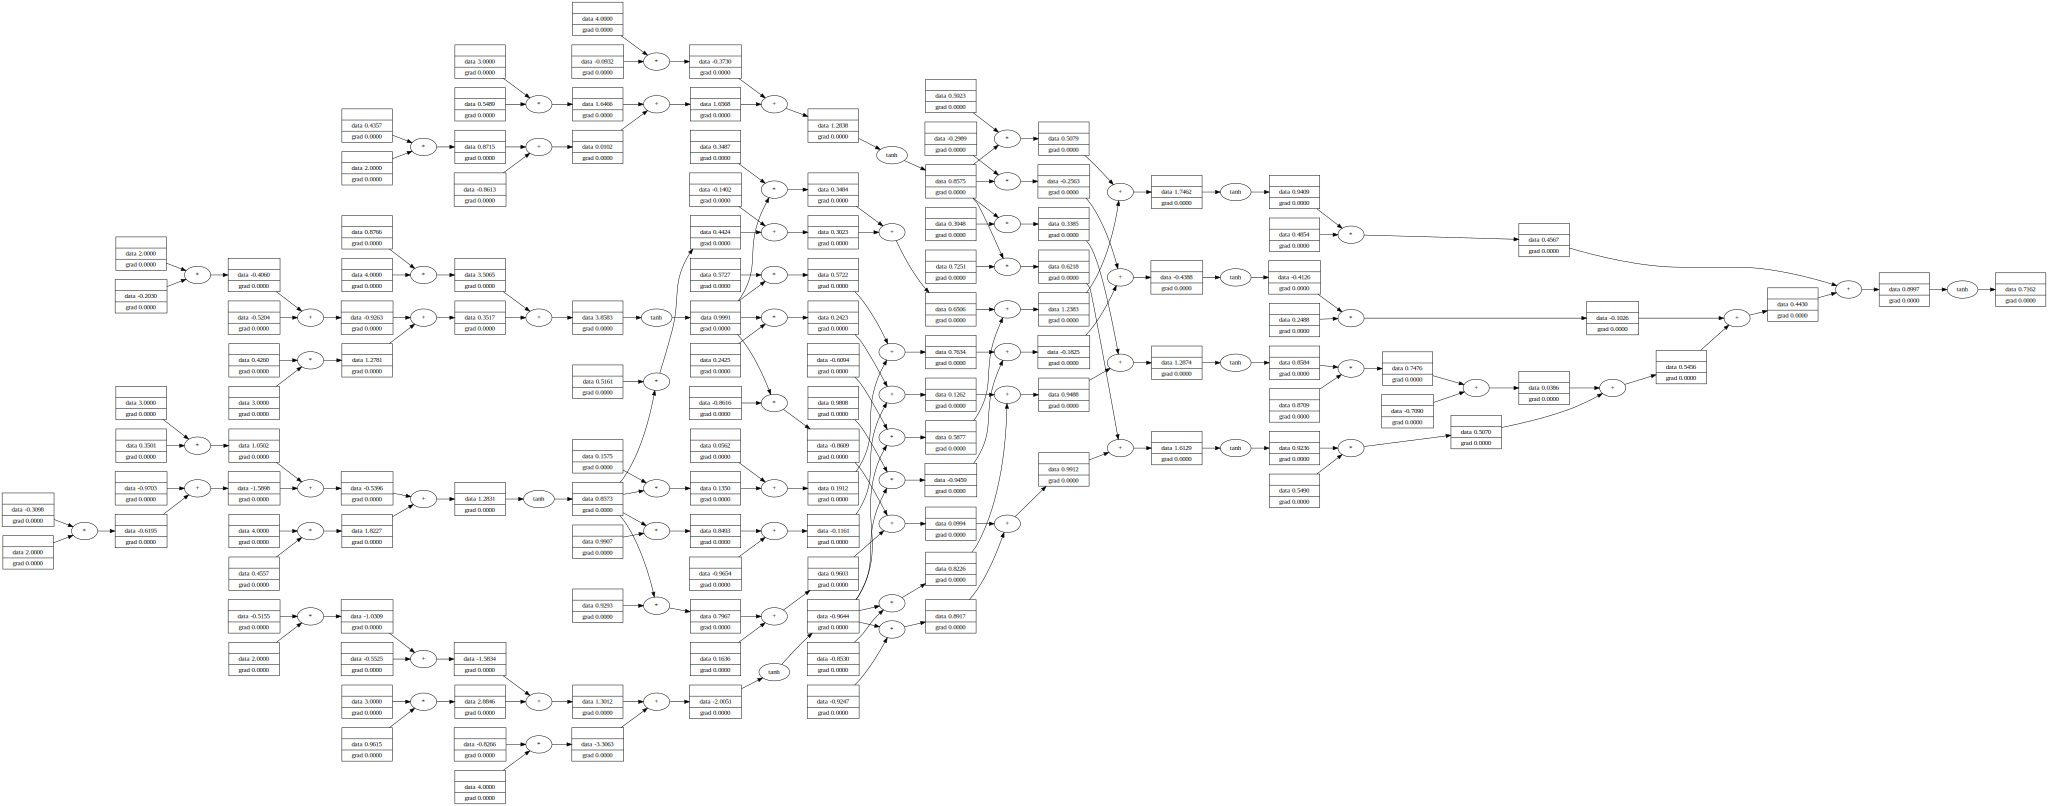

In [198]:
draw_dot(n(x))

Sample data

In [199]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [-1.0, -1.0, -1.0, 1.0] #targets

y_pred = [n(x) for x in xs]
y_pred

[Value(data=-0.9616874631234233),
 Value(data=-0.9081215124981102),
 Value(data=-0.8678489569886965),
 Value(data=-0.9735122304496475)]

Loss Function

In [200]:
loss = sum([(out - tgt) for tgt, out in zip(ys, y_pred)])
loss

Value(data=-1.7111701630598777)

In [201]:
loss.backward()

In [202]:
n.layers[0].neurons[0].w[0].grad

0.22279829428260248

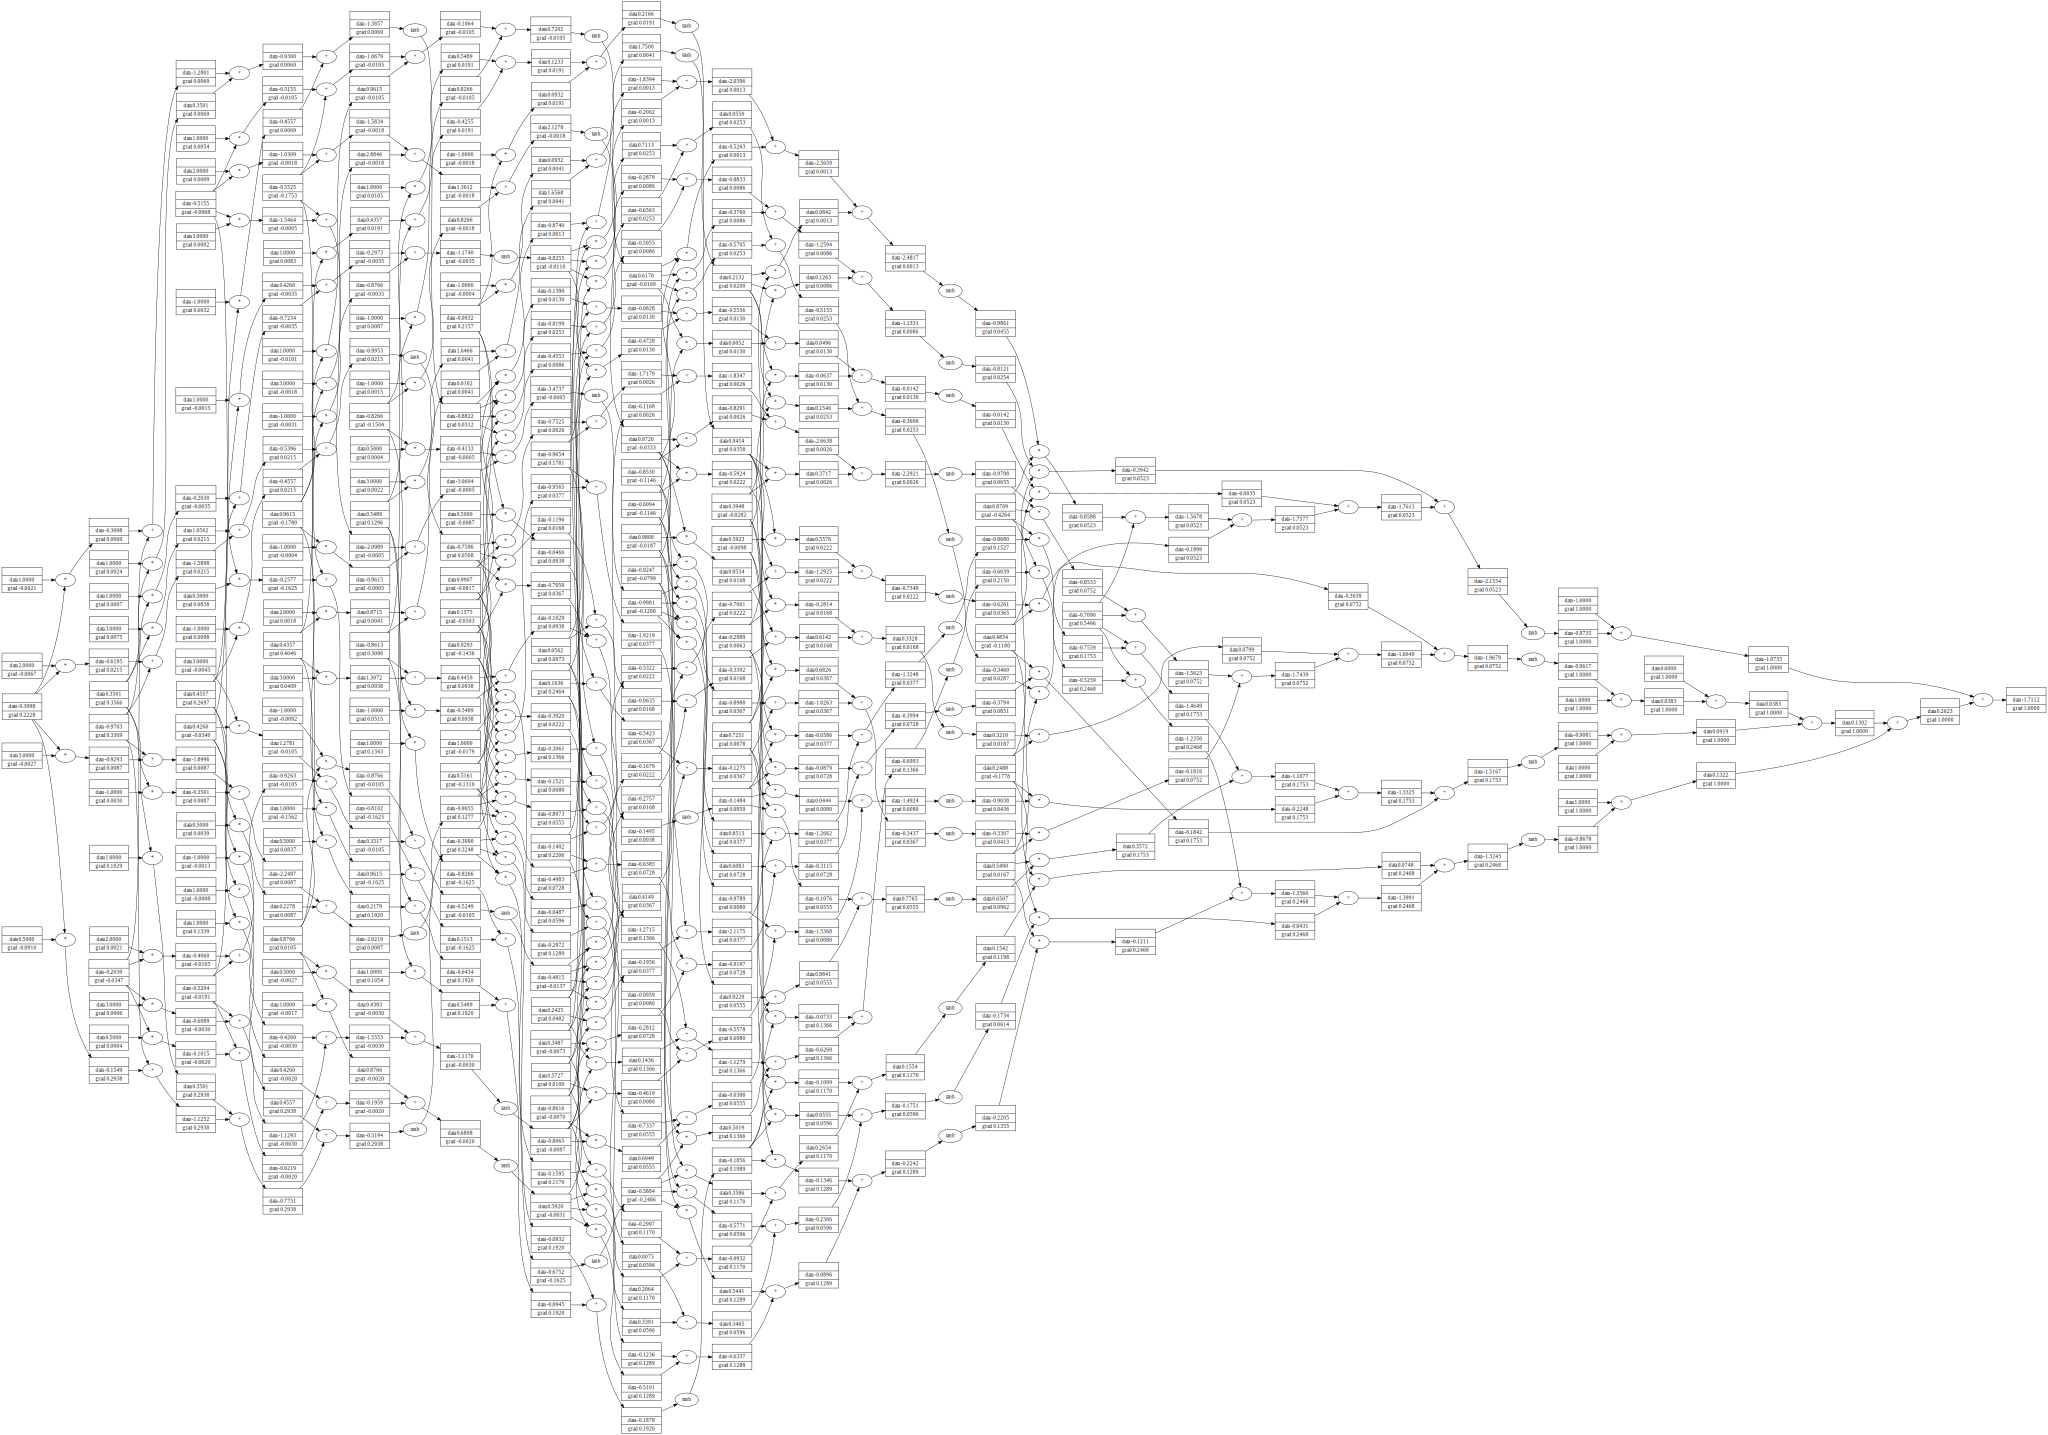

In [203]:
draw_dot(loss)

Implement params

In [204]:
class Neuron:

    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        #this is called when the instance of the class is called as n(x)

        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()

        return out
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:

    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [params for neuron in self.neurons for params in neuron.parameters()]

class MLP:

    def __init__(self, n_in, n_outs):
        #nouts is a list which defines sizes of all layers in mlp
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [params for layer in self.layers for params in layer.parameters()]

In [205]:
x = [2.0, 3.0, 4.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7920097273144653)

In [206]:
len(n.parameters())

41

In [207]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [-1.0, -1.0, -1.0, 1.0] #targets

y_pred = [n(x) for x in xs]
y_pred

[Value(data=0.8348285223683884),
 Value(data=-0.04863577311629396),
 Value(data=0.7972682912358765),
 Value(data=0.146299073354405)]

In [208]:
loss = sum([(out - tgt) for tgt, out in zip(ys, y_pred)])
loss

Value(data=3.729760113842376)

In [209]:
loss.backward()

In [210]:
n.layers[0].neurons[0].w[0].grad

0.20393044222436998

In [211]:
n.layers[0].neurons[0].w[0].data

0.5187099953651864

To minimize the loss we need to update the params in opposite dir of their gradient
- if grad is positive, the param should be dec
- if grad is negative, the param should be inc

In [212]:
for p in n.parameters():
    p.data += -0.01 * p.grad #negative sign updates in opp dir

In [213]:
n.layers[0].neurons[0].w[0].data

0.5166706909429427

Re-eval the loss

Forward pass

In [214]:
y_pred = [n(x) for x in xs]
loss = sum([(out - tgt)**2 for tgt, out in zip(ys, y_pred)])
loss

Value(data=7.968028232578249)

Backward pass

In [215]:
loss.backward()

Update

In [216]:
for p in n.parameters():
    p.data += -0.01 * p.grad #negative sign updates in opp dir

In [217]:
y_pred

[Value(data=0.798378459672459),
 Value(data=-0.16304755886542074),
 Value(data=0.755562342436132),
 Value(data=0.02461565449132166)]

In [223]:
for i in range(50):

    y_pred = [n(x) for x in xs]
    loss = sum([(out - tgt)**2 for tgt, out in zip(ys, y_pred)])
    print(loss)

    for p in n.parameters():
        p.grad = 0.0

    loss.backward()

    for p in n.parameters():
        p.data += -0.1 * p.grad

Value(data=0.13860177086856973)
Value(data=0.11061733019284618)
Value(data=0.09193057411445914)
Value(data=0.07855760404658346)
Value(data=0.06850597784259065)
Value(data=0.06067178764779231)
Value(data=0.05439353236211789)
Value(data=0.049250064954874405)
Value(data=0.044960195995392624)
Value(data=0.041328810717136025)
Value(data=0.03821616086894693)
Value(data=0.035519463761457315)
Value(data=0.03316140377779278)
Value(data=0.03108268683111923)
Value(data=0.029237069692246972)
Value(data=0.027587952527318618)
Value(data=0.02610598831868338)
Value(data=0.024767371107271143)
Value(data=0.02355258787012233)
Value(data=0.022445493580165506)
Value(data=0.021432615696027526)
Value(data=0.020502624229283062)
Value(data=0.019645923102295723)
Value(data=0.01885433156896639)
Value(data=0.01812083334520493)
Value(data=0.017439377226539585)
Value(data=0.016804717269585566)
Value(data=0.016212283671173593)
Value(data=0.015658077680675096)
Value(data=0.01513858548564505)
Value(data=0.014650707193

In [224]:
y_pred

[Value(data=-0.9469597248896705),
 Value(data=-0.9679014913343862),
 Value(data=-0.9730834485497072),
 Value(data=0.9335712455411802)]